In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

In [12]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model

In [13]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
#from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [14]:
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles

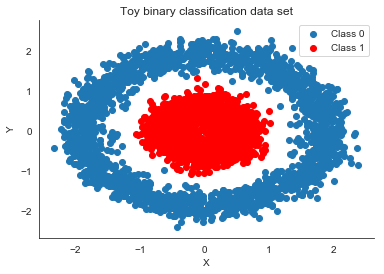

In [15]:
X, Y = make_circles(noise=0.1, factor=0.3, random_state=1, n_samples=4000, shuffle=True)
#X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [16]:
dim_num_dense_nodes = Integer(low=2, high=40, name='num_dense_nodes')

In [17]:
dimensions = [dim_num_dense_nodes]

In [18]:
default_parameters = [2]

In [106]:
def create_model(num_dense_nodes):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    
    # Start construction of a Keras Sequential model.
    model = Sequential()
    model.add(InputLayer(input_shape=(2,)))
    # Add the dense / fully-connected layer to the model.
    # This has two hyper-parameters we want to optimize:
    # The number of nodes and the activation function.
    model.add(Dense(num_dense_nodes,
                    activation='sigmoid'))

    model.add(Dense(num_dense_nodes,
                    activation='tanh'))
    
    model.add(Dense(num_dense_nodes,
                    activation='sigmoid'))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(1, activation='sigmoid'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=0.00001)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [107]:
best_accuracy = 0.0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []

In [108]:
@use_named_args(dimensions=dimensions)
def fitness(num_dense_nodes):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('num_dense_nodes:', num_dense_nodes)
   
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(num_dense_nodes=num_dense_nodes)

 
    # Use Keras to train the model.
    history = model.fit(x=X_train,
                        y=Y_train,
                        epochs=2,
                        validation_data=(X_test, Y_test)
                       )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # save parameter and accuracy history
    parameter_hist.append(num_dense_nodes)
    acc_hist.append(accuracy)
    
    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
       
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [109]:
# default parameter is 2 nodes per layer
default_parameters = [2]

In [110]:
fitness(x=default_parameters)

num_dense_nodes: 2

Train on 2000 samples, validate on 2000 samples
Epoch 1/2
2000/2000 [==============================] - 1s 338us/step - loss: nan - acc: 0.5125 - val_loss: nan - val_acc: 0.4875
Epoch 2/2
2000/2000 [==============================] - 0s 130us/step - loss: nan - acc: 0.5125 - val_loss: nan - val_acc: 0.4875

Accuracy: 48.75%



-0.4875

In [111]:
#start searching hyper parameter with gp
# we will do 11 call of fitness function, start with default parameters
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=22,
                            x0=default_parameters)

num_dense_nodes: 2

Train on 2000 samples, validate on 2000 samples
Epoch 1/2
2000/2000 [==============================] - 1s 284us/step - loss: nan - acc: 0.5125 - val_loss: nan - val_acc: 0.4875
Epoch 2/2
2000/2000 [==============================] - 0s 132us/step - loss: nan - acc: 0.5125 - val_loss: nan - val_acc: 0.4875

Accuracy: 48.75%

num_dense_nodes: 10

Train on 2000 samples, validate on 2000 samples
Epoch 1/2
2000/2000 [==============================] - 1s 293us/step - loss: nan - acc: 0.5175 - val_loss: nan - val_acc: 0.4875
Epoch 2/2
2000/2000 [==============================] - 0s 128us/step - loss: nan - acc: 0.5125 - val_loss: nan - val_acc: 0.4875

Accuracy: 48.75%

num_dense_nodes: 25

Train on 2000 samples, validate on 2000 samples
Epoch 1/2
2000/2000 [==============================] - 1s 277us/step - loss: nan - acc: 0.5125 - val_loss: nan - val_acc: 0.4875
Epoch 2/2
2000/2000 [==============================] - 0s 129us/step - loss: nan - acc: 0.5125 - val_loss: nan 